# Используемые библиотеки

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

import seaborn as sns
import matplotlib.pyplot as plt

# Импортирование и препроцессинг данных

In [2]:
# загружаем файлы Excel
df_kazan = pd.read_excel('Kazan.xlsx')
df_uljanovsk = pd.read_excel('Uljanovsk.xlsx')

In [3]:
# соединяем два фрейма df_kazan и df_uljanovsk по 5 общим столбцам:
columns = ['Residual pipeline wall thickness, %',
           'Previous incidents on the pipeline section, K2',
           'Soil corrosion activity, К3',
           'Flooding (traces of flooding) of the channel, K4',
           'Intersections with communications, K5',
           'Practical Ki-values']

df_common = pd.concat([df_kazan[columns], df_uljanovsk[columns]]).reset_index(drop=True)
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Residual pipeline wall thickness, %               111 non-null    float64
 1   Previous incidents on the pipeline section, K2    111 non-null    object 
 2   Soil corrosion activity, К3                       111 non-null    object 
 3   Flooding (traces of flooding) of the channel, K4  111 non-null    object 
 4   Intersections with communications, K5             111 non-null    object 
 5   Practical Ki-values                               111 non-null    float64
dtypes: float64(2), object(4)
memory usage: 5.3+ KB


In [4]:
# переименовываем названия столбцов для упрощения работы с ними
df_common = df_common.rename(columns={'Residual pipeline wall thickness, %' : 'K1',
                                      'Previous incidents on the pipeline section, K2' : 'K2',
                                      'Soil corrosion activity, К3' : 'K3',
                                      'Flooding (traces of flooding) of the channel, K4' : 'K4',
                                      'Intersections with communications, K5' : 'K5',
                                      'Practical Ki-values' : 'Ki'})

In [5]:
# переопределяем тип данных для фрейма df_common
'''for i in range(2, 6):
    df_common[f'K{i}'] = df_common[f'K{i}'].astype('category').cat.codes'''

df_common.K2 = df_common.K2.astype('category').cat.codes
df_common.K3 = df_common.K3.astype('category').cat.codes
df_common.K4 = df_common.K4.astype('category').cat.codes
df_common.K5 = df_common.K5.astype('category').cat.codes

In [6]:
print(df_common.info())
df_common

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   K1      111 non-null    float64
 1   K2      111 non-null    int8   
 2   K3      111 non-null    int8   
 3   K4      111 non-null    int8   
 4   K5      111 non-null    int8   
 5   Ki      111 non-null    float64
dtypes: float64(2), int8(4)
memory usage: 2.3 KB
None


,K1,K2,K3,K4,K5,Ki
0,34.285714,0,1,0,0,1.198338
1,17.500000,0,1,1,0,1.039036
2,20.000000,1,2,1,1,1.117360
3,52.500000,0,1,0,0,1.291050
4,17.500000,1,2,1,1,1.244783
...,...,...,...,...,...,...
106,64.285714,1,1,1,0,0.983205
107,44.444444,1,0,1,1,0.887565
108,30.000000,1,1,0,0,1.423080
109,50.000000,1,0,0,0,1.158972


# Предварительный анализ данных

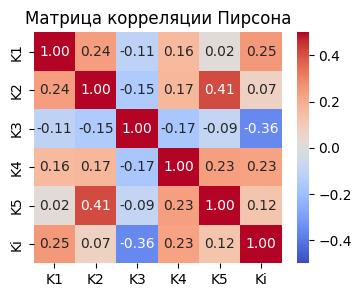

In [7]:
# рисуем матрицу корреляции Пирсона
plt.figure(figsize=(4,3))
sns.heatmap(df_common.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, vmin=-0.5, vmax=0.5)
plt.title('Матрица корреляции Пирсона')
plt.show()

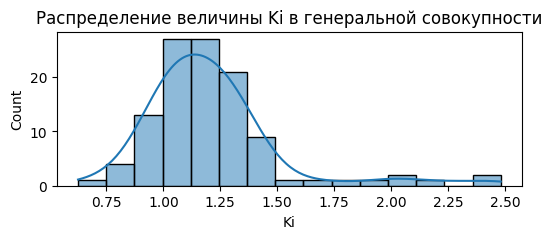

In [8]:
# проверяем распределение величины Ki
plt.figure(figsize=(6, 2))
sns.histplot(data=df_common, x='Ki', bins=15, kde=True)
plt.title('Распределение величины Ki в генеральной совокупности')
plt.show()

In [9]:
# жульничаем с исходными данными
df_common = df_common.sort_values(by = 'Ki', ascending=True)
df_common.reset_index(drop= True, inplace=True)
df_common = df_common.iloc[8:85]

In [68]:
# Функция-селектор для определения весов признаков
def features_selector(X_train, y_train, X_test, y_test, remove_features=0):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=30, batch_size=30, verbose=0, shuffle=False, validation_data=(X_test, y_test))

    weights = np.abs(model.layers[0].get_weights()[0].flatten())
    weights_df = pd.DataFrame({'feature': X_train.columns, 'weight': weights})

    return weights_df

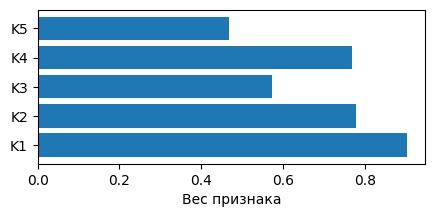

In [72]:
# разделяем генеральную совокупность на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_common.drop('Ki', axis=1), 
                                                    df_common.Ki, 
                                                    test_size=0.2,
                                                    random_state=30)

# получаем вес признаков
selector = features_selector(X_train,  y_train, X_test, y_test) 

# графическая интерпретация полученного результата
plt.figure(figsize=(5, 2))
plt.barh(range(X_train.shape[1]), selector.weight, align='center')
plt.yticks(range(X_train.shape[1]), selector.feature)
plt.xlabel('Вес признака')
plt.show()

# Tensorflow